## Document Classification.

In [26]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline


In [27]:
df = pd.read_csv("shuffled-full-set-hashed.csv", header = None)
df.columns = ['Category', 'Content']
display(df.head())
print("Shape of data is : {}".format(df.shape))

,Category,Content
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...


Shape of data is : (62204, 2)


In [ ]:
cnt_categories = df['Category'].value_counts()

plt.figure(figsize=(12,4))
g = sns.barplot(cnt_categories.index, cnt_categories.values, alpha=0.9)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)

plt.show()
print(cnt_categories)

In [25]:
# term frquency and document frequency vectorizer. Max_df and Min_df will filter out 
# terms that are very common(present in more than 70% of documents) or very rare(present in less than 1% documents)
# we will consider both 1 gram and 2 grams.
tfidf = TfidfVectorizer(sublinear_tf=True, max_df = 0.44, min_df = 0.01, norm='l2', ngram_range=(1, 2))

features = tfidf.fit_transform(df['Content'].values.astype('U')).toarray()
labels = df['Category']
features.shape

(61620, 3651)

In [ ]:
N = 2
MAX = 4
i = 0
for Product, category_id in sorted(labels.items()):
    if i > MAX:
        break
    i = i + 1
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [ ]:
models = [
    LinearSVC(),
    LogisticRegression(random_state=0),
]
CV = 5

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


In [ ]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [26]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, 
                                                                                 test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

In [27]:
print(accuracy_score(y_test, y_pred))

0.8738234339500163


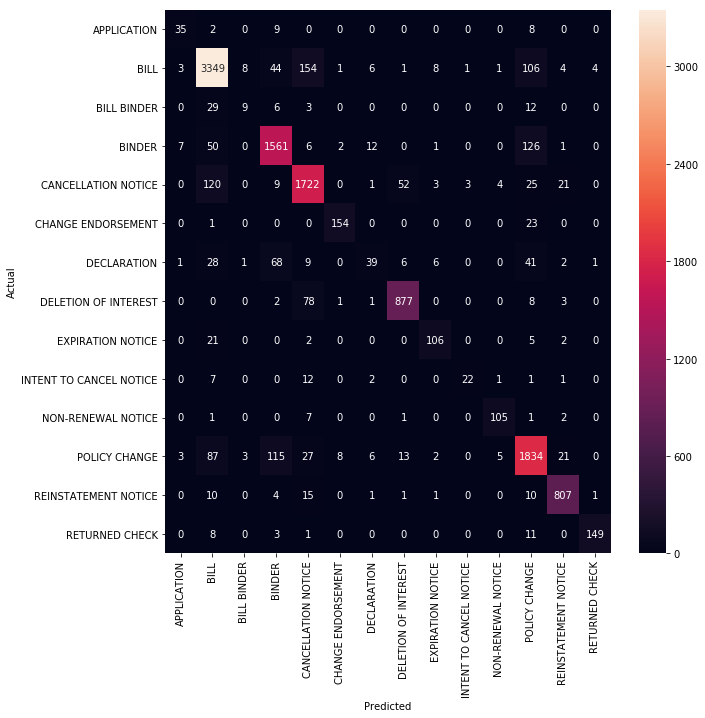

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
category_ids = df.groupby(['Category']).count().index
sns.heatmap(conf_mat, annot=True, fmt='d',
           xticklabels=category_ids, yticklabels=category_ids)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [29]:
from sklearn.externals import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']

In [30]:
test_data

,Category,Content
38396,BILL,3465ba174344 0beb9c74e2d3 fe3fe35491b4 189f09e...
61485,BILL,e0a718aaedd9 dee46d35626e e7e059c82399 b80facf...
35201,BILL,036087ac04f9 b136f6349cf3 6ca2dd348663 d388206...
26941,BILL,25c57acdf805 ce1f034abb5d 330f928ed5ce 422068f...
35533,CANCELLATION NOTICE,2dd786866fc1 4e5019f629a9 c4b9b465156f 26f7353...
45809,BILL BINDER,8d21095e8690 b208ae1e8232 81754cd738c6 6365c45...
5657,BINDER,f999a6afce31 3cb4a40c2b29 82ef4725a8b4 eeb86a6...
22122,POLICY CHANGE,cb7631b88e51 ba02159e05b1 97b6014f9e50 e7e059c...
20416,BINDER,a3041ad21875 bd50a6b2259f 1160c83555d2 6dc87f8...
16249,CANCELLATION NOTICE,8329bcfb80ba 25c57acdf805 ee94f34a89db f7ae6f8...


In [32]:
features_train, features_test, labels_train, labels_test = train_test_split(df['Content'], df['Category'], random_state = 42, test_size=0.34)

### CountVectorizer
##
#
cv = TfidfVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.44, norm='l2')
features_train_cv = cv.fit_transform(features_train.values.astype('U'))
# Uncomment to print a matrix count of tokens
# print(features_train_cv.toarray())
print("Feature Count\nCountVectorizer() #", len(cv.get_feature_names()))


tfidfv = TfidfTransformer(use_idf=True)
tfidfv = TfidfVectorizer(sublinear_tf=True, max_df = 0.44, min_df = 0.01, ngram_range=(1, 2))
features_train_tfidfv = tfidfv.fit_transform(features_train_cv)
print("Feature Set\nTfidfVectorizer() #", features_train_tfidfv.shape)

selector = SelectKBest(chi2, k=1000)
selector.fit(features_train_tfidfv, labels_train)

clf = LinearSVC()
clf.fit(selector.transform(features_train_tfidfv), labels_train)


### Test Model
##
#
features_test_cv = cv.transform(features_test.values.astype('U'))
features_test_cv_two = tfidfv.transform(features_test_cv)
features_test_cv = selector.transform(features_test_cv_two)
pred = clf.predict(features_test_cv)

Feature Count
CountVectorizer() # 3762
Feature Set
TfidfVectorizer() # (1649, 3762)


ValueError: Expected 2D array, got scalar array instead:
array=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.44, max_features=None, min_df=0.01,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [34]:
features_train, features_test, labels_train, labels_test = train_test_split(df['Content'], df['Category'], random_state = 42, test_size=0.34)

### TfidfVectorizer
cv = TfidfVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.44, norm='l2')
features_train_cv = cv.fit_transform(features_train.values.astype('U'))

print("Feature Count\nCountVectorizer() #", len(cv.get_feature_names()))

selector = SelectKBest(chi2, k=1000)
selector.fit(features_train_cv, labels_train)

clf = LinearSVC()
clf.fit(selector.transform(features_train_cv), labels_train)


features_test_cv = cv.transform(features_test.values.astype('U'))
features_test_cv = selector.transform(features_test_cv)
pred = clf.predict(features_test_cv)
pred

Feature Count
CountVectorizer() # 3762


array(['BILL', 'BINDER', 'CANCELLATION NOTICE', 'BILL',
       'DELETION OF INTEREST', 'BINDER', 'CANCELLATION NOTICE',
       'POLICY CHANGE', 'BINDER', 'CANCELLATION NOTICE', 'BILL',
       'POLICY CHANGE', 'BINDER', 'REINSTATEMENT NOTICE',
       'DELETION OF INTEREST', 'BILL', 'BINDER', 'POLICY CHANGE',
       'BINDER', 'POLICY CHANGE', 'CANCELLATION NOTICE', 'BILL',
       'POLICY CHANGE', 'POLICY CHANGE', 'BILL', 'BILL',
       'REINSTATEMENT NOTICE', 'CANCELLATION NOTICE', 'BINDER',
       'DELETION OF INTEREST', 'BILL', 'REINSTATEMENT NOTICE', 'BINDER',
       'REINSTATEMENT NOTICE', 'BILL', 'CANCELLATION NOTICE', 'BILL',
       'BILL', 'POLICY CHANGE', 'BILL', 'BILL', 'BILL', 'BINDER',
       'POLICY CHANGE', 'BILL', 'POLICY CHANGE', 'BILL', 'BILL',
       'POLICY CHANGE', 'CANCELLATION NOTICE', 'BILL',
       'CANCELLATION NOTICE', 'CANCELLATION NOTICE', 'POLICY CHANGE',
       'POLICY CHANGE', 'BILL', 'BINDER', 'BILL', 'CANCELLATION NOTICE',
       'REINSTATEMENT NOTICE', 'B

In [28]:
(features_train, labels_train) = (df['Content'].values.astype('U'), df['Category'])

### TfidfVectorizer
tfidfv = TfidfVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.44, norm='l2')

## Selector
selector = SelectKBest(chi2, k=1000)

linearsvc = Pipeline([('vect', tfidfv),
                ('selector', selector),
                ('clf', clf),
               ])
linearsvc.fit(features_train, labels_train)

from sklearn.externals import joblib
joblib.dump(linearsvc, 'model.pkl')

['model.pkl']

In [37]:
from sklearn.externals import joblib
joblib.dump(linearsvc, 'model_2.pkl', protocol=2)

['model_2.pkl']

In [30]:
classifier = open('model.pkl', 'rb')
model = joblib.load(classifier)

In [43]:
(features_train, labels_train) = (df.loc[1:40,'Content'].values.astype('U'), df.loc[1:40,'Category'])

### TfidfVectorizer
tfidfv = TfidfVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.44, norm='l2')

## Selector
selector = SelectKBest(chi2, k=1000)

linearsvc = Pipeline([('vect', tfidfv),
                ('selector', selector),
                ('clf', clf),
               ])
linearsvc.fit(features_train, labels_train)

from sklearn.externals import joblib
joblib.dump(linearsvc, 'model_light.pkl', protocol=2)

['model_light.pkl']